In [1]:
# need a training dataset of simulated X_i = (T_i,Cv_i) data and the corresponding spectrum vectors s_j

import numpy as np
from matplotlib import pyplot as plt

# boltzmann constant in meV per Kelvin
kB = 0.08617

# phonon DOS properties (units are meV)
n = 128 # length of output array
wmax = 120 # ouput spectra will cover range [dw, wmax]
dw = wmax/(1.*n) # spectrum bin width

# range for Debye spectra (meV)
wDmin = 10
wDmax = 40

# range for width of optical modes
sigbar = 10

# temperature vector properties (units are Kelvin)
m = 128 # length of temperature array
#
# temperatures are log uniform distributed in the range [0.1, 300]
# i.e. T~exp(U[log(0.1),log(300)])
#
Tmin = 0.1 # minimum temp
Tmax = 300 # maximum temp



In [2]:
# makeT produces a vector of sorted, log-uniform distributed temperatures in the range [Tmin,Tmax]

def makeT(m):
    logTmax = np.log(Tmax)
    logTmin = np.log(Tmin)
    return np.sort(np.exp(np.random.uniform(logTmin, logTmax, m)))


In [3]:
# here I work on modelling the density of states

# makeW returns a vector of n omega (energy) values, up to wmax
def makeW(n):
    dw = wmax/(n*1.)
    return np.linspace(dw, wmax, n)

# debyeMode is normalized to 1, and takes the Debye frequency as a parameter
# logical test implements the cutoff for w > wD
def debyeSpectrum(w,wD):
    return (w<=wD)*3*w*w/(wD*wD*wD)

# opticalMode is also normalized to 1
# models an optical phonon mode as a higher frequency Gaussian with mean mu and width sig
def opticalMode(w, wbar, sig):
    return np.exp(-0.5*(w-wbar)*(w-wbar)/(sig*sig))/np.sqrt(2*np.pi*sig*sig)

# genSpectrum produces a Debye spectrum plus a random number of optical modes
def genSpectrum(w):
    # acoustic modes
    s = np.zeros(len(w)) # initialize spectrum
    wD = np.random.uniform(wDmin, wDmax) # randomly draw Debye frequency from uniform distribution
    s += debyeSpectrum(w, wD) # update spectrum vector
    # optical modes
    n = np.random.randint(0,5) # number of optical modes
    if n==0: # no need to proceed
        return dw*debyeSpectrum(w,wD)
    wbar = np.random.uniform(wD, 0.75*max(w), n) # generate n positions for optical modes in range [wD, 0.5wmax]
    sig = np.random.normal(sigbar, sigbar/3, n) # generate n widths for optical modes 
    for i in range(n):
        s += opticalMode(w, wbar[i], sig[i])
    return dw*s/(n+1.)
    

1.00920448742711


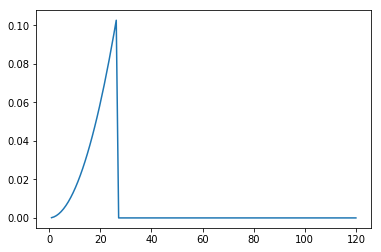

In [4]:
# checking the simulated phonon DOS
w = makeW(n)
dos = genSpectrum(w)
# check normalization, should be ~1 (very poor integration approximation)
print np.sum(dos)
# plot
plt.plot(w,dos)

In [5]:
# now work on calculating the heat capacity
def kernel(w, T):
    y = np.outer(1/T/kB, w) # m x n matrix
    #return y
    return y*y*np.exp(-y)/(np.exp(-y)-1)**2

def cv(w, T):
    dos = genSpectrum(w)
    return [np.dot(kernel(w, T), dos), dos]
    

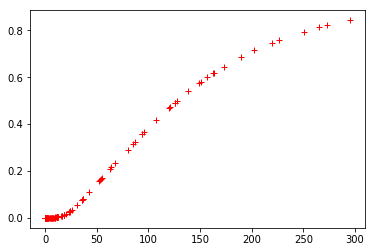

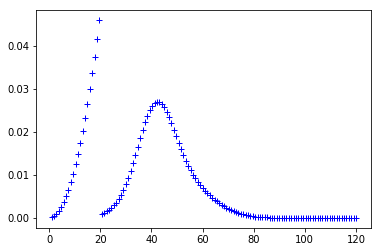

In [6]:
# plot the simulated heat capacity and underlying phonon DOS
T = makeT(m)
w = makeW(n)
[X, Y] = cv(w, T)

plt.figure(1)
plt.plot(T,X,'r+')
plt.figure(2)
plt.plot(w,Y,'b+')


In [8]:
def genData(p):
    X = np.zeros((p, 2, n))
    Y = np.zeros((p, m))
    for i in range(p):
        [x, y] = cv(w, T)
        X[i][0] = T
        X[i][1] = x
        Y[i] = y
    return [X, Y]


[66 64 78  3 79]


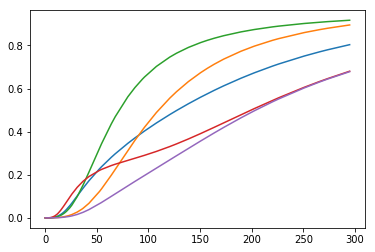

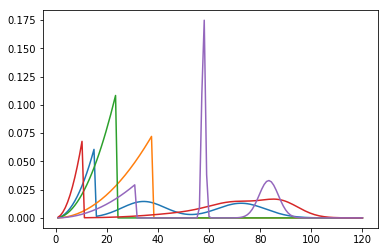

In [10]:
# test the genData function
p=100
[X, Y] = genData(p)
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X[i][0],X[i][1])
    plt.figure(1)

    plt.plot(w,Y[i])

[33 56  7 91 96]


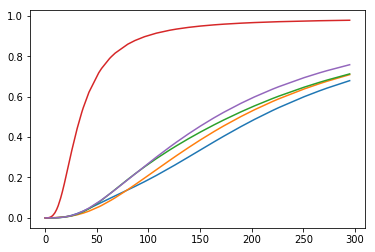

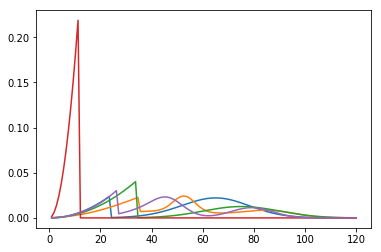

In [11]:
# more plots
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X[i][0],X[i][1])
    plt.figure(1)
    plt.plot(w,Y[i])

In [ ]:
# export training data to file
import pandas as pd

p = 60000 # number of training data
q = 10000 # number of test data

[X_train, Y_train] = genData(p)
[X_test, Y_test] = genData(q)

# need to reshape the X data to be 2D
x_train = np.reshape(X_train,(p, 2*m))
x_test = np.reshape(X_test,(q, 2*m))

# pickle data using pandas and compress using BZIP2
pd.DataFrame(x_train).to_pickle("./training_data/X_train.bz2")
pd.DataFrame(Y_train).to_pickle("./training_data/Y_train.bz2")
pd.DataFrame(x_test).to_pickle("./training_data/X_test.bz2")
pd.DataFrame(Y_test).to_pickle("./training_data/Y_test.bz2")

In [ ]:
# read pickled data and check it recreates X
x_read = pd.read_pickle("./training_data/X_train.bz2")
x_read = x_read.values # back to numpy array
print np.shape(x_read)
X_read = np.reshape(x_read,(p, 2, m))
# sum the differences between the vectors
np.sum(X_train - X_read)